# This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

## Update the John Holkins, Covid-19 data 
https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [51]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

## Prepare arguments for driver

In [52]:
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Confirmed',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

## Load John Hopkins data

The "data date" is 2020-08-06 00:00:00

ADF Statistic: -2.075695
p-value: 0.254399
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


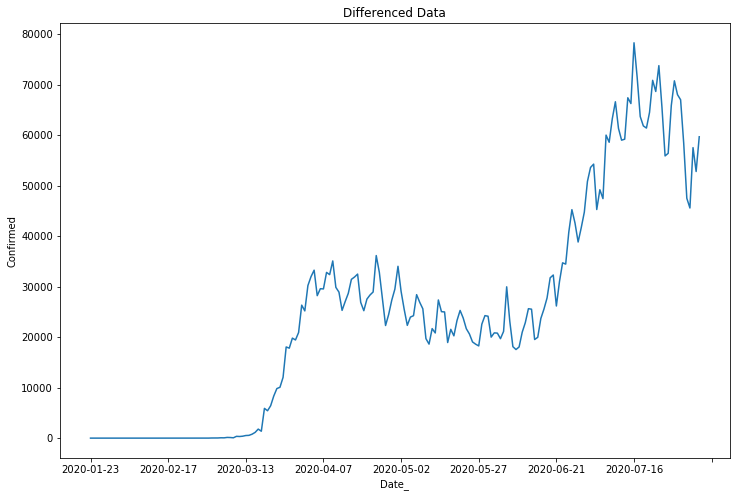

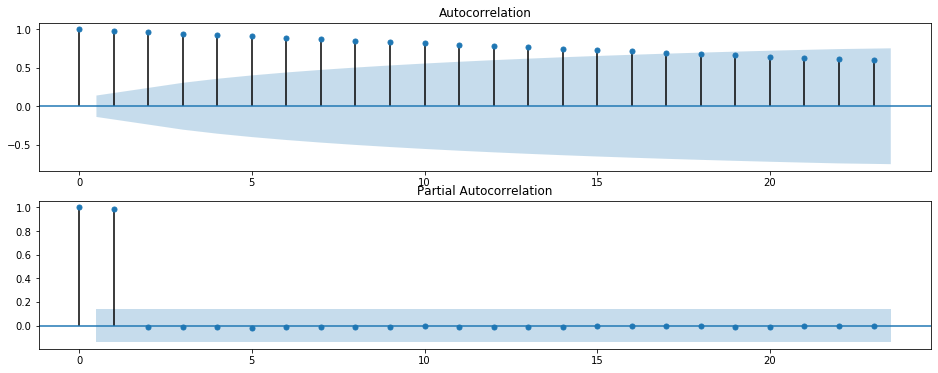

ARIMA(0, 0, 1) RMSE=1387048.206
ARIMA(0, 1, 1) RMSE=23312.281
ARIMA(0, 2, 1) RMSE=4738.591
ARIMA(0, 2, 2) RMSE=4836.533
ARIMA(1, 0, 0) RMSE=43028.074
ARIMA(1, 1, 0) RMSE=4725.884
ARIMA(1, 2, 0) RMSE=4740.785
ARIMA(1, 2, 1) RMSE=4681.190
ARIMA(1, 2, 2) RMSE=4657.045
ARIMA(2, 1, 0) RMSE=4880.946
ARIMA(2, 2, 0) RMSE=4786.316
ARIMA(2, 2, 1) RMSE=4634.699
Best ARIMA(2, 2, 1) RMSE=4634.699
RMSE: 4634.699
       Residual Statistics
count            99.000000
mean            398.783360
std            4641.009833
min          -10974.809077
25%           -1910.575746
50%             215.331556
75%            3120.062853
max           13067.196190


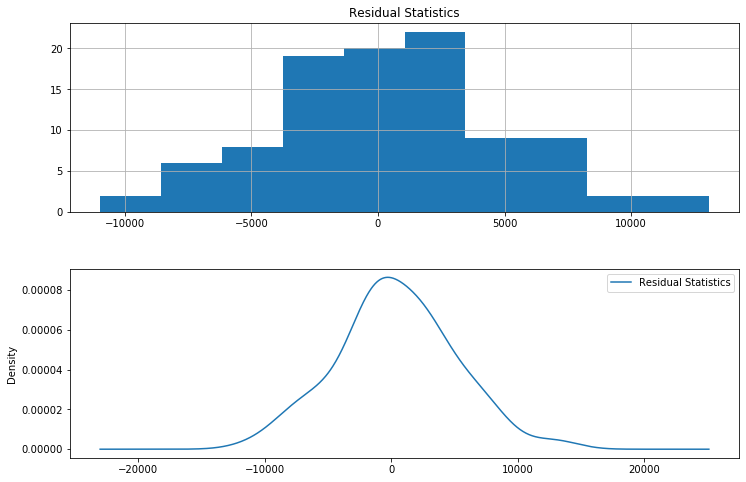


bias IS saved in arg_dict["bias"] for subsequent run is: 398.7833597672506 

RMSE: 4617.511
       Residual Statistics
count         9.900000e+01
mean          9.407299e-12
std           4.641010e+03
min          -1.137359e+04
25%          -2.309359e+03
50%          -1.834518e+02
75%           2.721279e+03
max           1.266841e+04


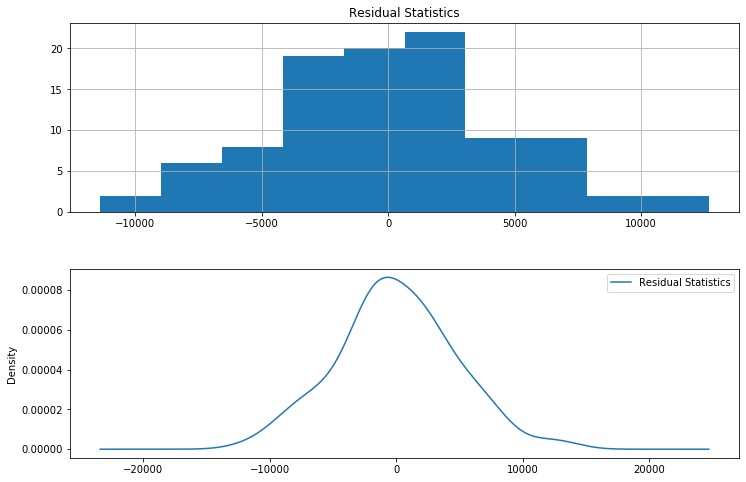


bias NOT saved in arg_dict["bias"] for subsequent run is: 9.407298733489683e-12 



In [53]:
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Plot test (actual) vs predictions, save, and forecast

The predicted cumulative Confirmed for USA for tomorrow (input data plus 1 day) are 4,875,956


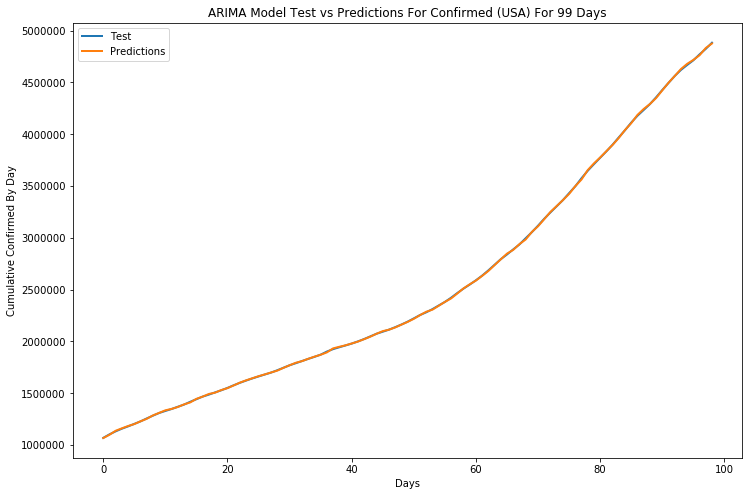

In [54]:
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

## Multi step forecast

The USA prediction is for 16,700,523 cumulative Confirmed to occur by 2020-12-31 00:00:00


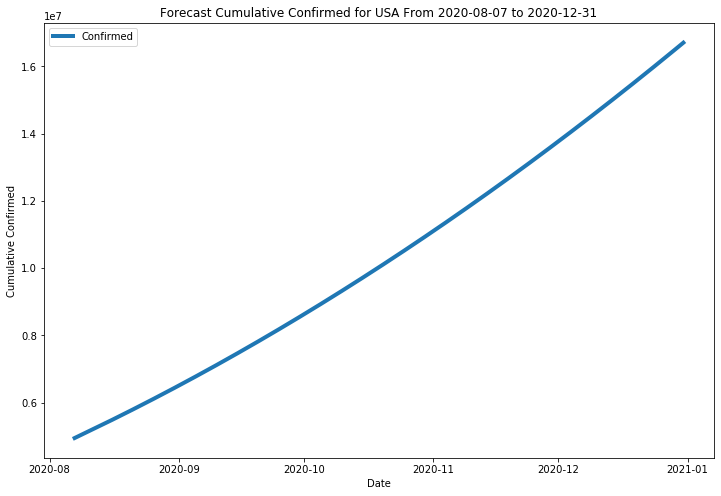

In [55]:
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [56]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Confirmed,Daily_Confirmed
Date_,,
2020-08-02,4667955.0,47511.0
2020-08-03,4713540.0,45585.0
2020-08-04,4771080.0,57540.0
2020-08-05,4823890.0,52810.0
2020-08-06,4883582.0,59692.0


In [57]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Confirmed,Daily_Confirmed
Date_,,
2020-08-07,4944446.0,60864.0
2020-08-08,5004141.0,59695.0
2020-08-09,5063382.0,59241.0
2020-08-10,5122684.0,59302.0
2020-08-11,5182293.0,59609.0
